In [1]:

from BondFlow.data.dataloader_test import get_dataloader
from BondFlow.models.Loss import *
import torch
import os
import random
import numpy as np
from collections import defaultdict


/home/fit/lulei/WORK/.conda/envs/apm_env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, weight, bias=None):
/home/fit/lulei/WORK/.conda/envs/apm_env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:70: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):


In [2]:
from BondFlow.data import utils as iu
import logging
import torch.nn as nn


import torch

import logging
from hydra.core.hydra_config import HydraConfig
import numpy as np
import random
import hydra
from hydra import initialize, compose
from BondFlow.models.mymodel import *

from omegaconf import OmegaConf

def make_deterministic(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


#conf.inference.ckpt_override_path= "../Train/weights_base3/best_model.pth"
config_file = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/base.yaml"
config_path = os.path.dirname(config_file)
config_path = os.path.relpath(config_path)
config_name = os.path.basename(config_file).split(".yaml")[0]

# 创建模型 + DDP包装 
with initialize(version_base=None, config_path=config_path):
    conf = compose(config_name=config_name)
# with initialize(version_base=None, config_path="../config/inference"):
#     conf = compose(config_name="base")
# 调用主函数
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

log = logging.getLogger(__name__)
if conf.inference.deterministic:
    make_deterministic()

# Check for available GPU and print result of check
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    log.info(f"Found GPU with device_name {device_name}. Will run RFdiffusion on {device_name}")
else:
    log.info("////////////////////////////////////////////////")
    log.info("///// NO GPU DETECTED! Falling back to CPU /////")
    log.info("////////////////////////////////////////////////")

# Initialize sampler and target/contig.
sampler = MySampler(conf,device=device)  # 使用传入的 device 参数

loading APMBackboneWrapper
loading APMBackboneWrapper
[APMBackboneWrapper] Loaded wrapper from /home/fit/lulei/WORK/xjt/Protein_design/BondFlow/Train/weight_apm_backbone_monomer38/best_model.pth: loaded~767/1340, missing=0, unexpected=573, strict=False
loading APMSidechainWrapper
loading APMSidechainWrapper
[APMSidechainWrapper] Loaded wrapper from /home/fit/lulei/WORK/xjt/Protein_design/BondFlow/Train/weight_apm_sidechain_monomer17/best_model.pth: loaded~550/1123, missing=0, unexpected=573, strict=False


In [3]:
batch_size = 1
pdb_list_path = "/home/fit/lulei/WORK/xjt/Protein_design/CyclicPeptide/Dataset/ALL_MMCIF/train_data4/LINK_tmp/cluster.tsv"
pdb_dir = "/home/fit/lulei/WORK/xjt/Protein_design/CyclicPeptide/Dataset/ALL_MMCIF/train_data4//LINK_CIF"
cache_dir = "/home/fit/lulei/WORK/xjt/Protein_design/CyclicPeptide/Dataset/ALL_MMCIF/data_cache/"
dataloader_train,dataloader_val = get_dataloader(conf, batch_size, pdb_list_path, pdb_dir,distributed=False, num_workers=0, 
                   crop_length=700, device='cpu',rank=None, num_replicas=None,seed=42,
                   val_split=0.025,sampling_ratios={'monomer': 1},mask_bond_prob = 0.0,mask_seq_str_prob = 0.0, 
                   cache_dir = cache_dir)
print(len(dataloader_train),len(dataloader_val))

Training set: 25681 clusters.
self.num_replicas None
self.rank None
self.total_size 25681
Validation set: 659 clusters.
self.num_replicas None
self.rank None
self.total_size 659
25681 659


In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params = count_parameters(sampler.model)
print(f"模型的参数总量: {params}")

模型的参数总量: 57489776


In [5]:
import numpy as np
import matplotlib.pyplot as plt
def plot_tensor_heatmap(tensor, title="Tensor Heatmap", cmap="viridis"):
    """
    绘制L×L tensor矩阵的热图
    
    参数:
    tensor -- 输入的L×L矩阵
    title -- 热图标题(可选)
    cmap -- 颜色映射(可选)
    """
    plt.figure(figsize=(8, 6))
    
    # 显示热图
    im = plt.imshow(tensor, cmap=cmap)
    
    # 添加颜色条
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    # 设置标题和坐标轴
    plt.title(title)
    plt.xlabel("Column Index")
    plt.ylabel("Row Index")
    
    # 显示网格线(可选)
    plt.grid(False)
    
    plt.show()



In [6]:

def log_nan_loss(loss_tensor, loss_name, pdb_id, log_file_path):
    """
    Logs a message if the loss is NaN.

    Args:
        loss_tensor (torch.Tensor): The loss value.
        loss_name (str): The name of the loss (e.g., 'frame', 'seq').
        batch_data (dict): The batch data dictionary, containing 'pdb_id'.
        log_file_path (str): The path to the log file.
    
    Returns:
        bool: True if the loss was NaN, False otherwise.
    """
    if torch.isnan(loss_tensor):
        with open(log_file_path, 'a') as f:
            pdb_ids = " ".join(pdb_id)
            log_message = f"{loss_name} nan {pdb_ids} {loss_tensor.item()}\\n"
            f.write(log_message)
            print(log_message)
        return True
    return False
log_file_path = "/home/fit/lulei/WORK/xjt/Protein_design/RFdiffusion/mytest/tests/train_log.txt"



def model_forward(sampler,batch_data,criterion_frame, criterion_seq, 
                                                criterion_bond,
                                                criterion_FAPE,
                                                criterion_torsion,
                                                criterion_bond_coh,
                                                criterion_sc_fape,
                                                eps_t = 5e-3,
                                                criterion_clash=None):
    
    # 1. Extract data from batch and move to device
    xyz_orig = batch_data['full_xyz'].to(sampler.device) # (B, L, 14, 3)
    seq_target = batch_data['full_seq'].to(sampler.device)
    bond_matrix_target = batch_data['full_bond_matrix'].to(sampler.device)
    res_mask = batch_data['res_mask'].to(sampler.device)
    str_mask = batch_data['full_mask_str'].to(sampler.device)
    seq_mask = batch_data['full_mask_seq'].to(sampler.device)
    bond_mask = batch_data['full_bond_mask'].to(sampler.device)
    head_mask = batch_data['full_head_mask'].to(sampler.device)
    tail_mask = batch_data['full_tail_mask'].to(sampler.device)
    pdb_idx = batch_data['full_pdb_idx']
    rf_idx = batch_data['full_rf_idx'].to(sampler.device)
    alpha_target = batch_data['full_alpha'].to(sampler.device)
    alpha_alt_target = batch_data['full_alpha_alt'].to(sampler.device)  # [L,10,2] for alpha torsions, [L,10,2] for alpha torsion alt
    alpha_tor_mask = batch_data['full_alpha_tor_mask'].to(sampler.device)
    pdb_id = batch_data['pdb_id']
    final_res_mask = res_mask.float() * (1 - head_mask.float()) * (1 - tail_mask.float())
    # alpha_target = torch.zeros_like(alpha_target)
    # alpha_target[:,:,:,0] = 0.6 
    # alpha_target[:,:,:,1] = 0.8 
    # alpha_alt_target = alpha_target
    


    
    # Create dummy tensors for ss since it's not in batch_data
    B, L = seq_target.shape


    xyz_centered = sampler._center_global(xyz_orig[:,:,:3,:], str_mask, res_mask, pdb_idx)


    print("xyz_noised 0",xyz_centered[0,0,...])
    print("xyz_noised 1",xyz_centered[0,1,...])

    # 4. Preprocess batch for the model
    res_dist_matrix, meta = sampler.bond_mat_2_dist_mat(bond_matrix_target, rf_idx, res_mask)
    # plot_tensor_heatmap(bond_noised[0].cpu(), title="Noised Bond Matrix")
    # print(bond_noised[0][(bond_noised[0]>0)& (bond_noised[0]<1)])
    # plot_tensor_heatmap(bond_noised[1].cpu(), title="Noised Bond Matrix")
    # plot_tensor_heatmap(bond_matrix_target[0].cpu(), title="Bond Matrix")
    # plot_tensor_heatmap(bond_matrix_target[1].cpu(), title="Bond Matrix")
    # print(bond_noised[1][(bond_noised[1]>0)& (bond_noised[1]<1)])
    # plot_tensor_heatmap(bond_mask[0].cpu(), title="Bond mask")
    # plot_tensor_heatmap(bond_mask[1].cpu(), title="Bond mask")
    
    # plot_tensor_heatmap(res_dist_matrix[0].cpu(), title="CA")
    # plot_tensor_heatmap(res_dist_matrix[1].cpu(), title="CA Dist Matrix")
    # 5. Model forward pass
    start_time = time.time()

    torsion_angles = sampler.sidechain_model(
            seq_noised=seq_target,
            xyz_noised=xyz_centered,
            bond_noised=bond_matrix_target,
            rf_idx=rf_idx,
            pdb_idx=pdb_idx,
            res_dist_matrix=res_dist_matrix,
            alpha_target=alpha_target,
            alpha_tor_mask=alpha_tor_mask,
            partial_T=None,
            str_mask=str_mask,
            seq_mask=seq_mask,
            head_mask=head_mask,
            tail_mask=tail_mask,
            bond_mask=bond_mask,
            res_mask=res_mask,
            use_checkpoint=False,
            # trans_1=xyz_centered[:,:,1,:].to(xyz_noised.dtype),
            # rotmats_1= rotmats.to(xyz_noised.dtype),
            # aatypes_1=seq_target.long(),

        )
    print("model forward time:", time.time() - start_time)
    
    # # return logits_2d, logits_aa, logits_exp, xyz_pred, alpha_s, bond_matrix, lddt
    # # 计算frame损失
    # times = xyz_pred.size(1)
    # target_times =xyz_centered.unsqueeze(1).expand(-1,times,-1,-1,-1)[...,:3,:]
    # noise_times = xyz_noised.unsqueeze(1).expand(-1,times,-1,-1,-1)[...,:3,:]
    # str_res_mask = str_mask.float() * res_mask.float() 
    # # print("center of xyz_pred:",xyz_pred[...,1,:].mean(dim=(1,2)))
    # # print("center of xyz_noised:",noise_times[...,1,:].mean(dim=(1,2)))
    # # print("center of xyz_target:",target_times[...,1,:].mean(dim=(1,2)))
    # loss_frame_start = time.time()
    # loss_frame = criterion_frame(xyz_pred, target_times,noise_times, mask = str_res_mask.bool(),t=partial_T)
    # log_nan_loss(loss_frame, 'frame', pdb_id, log_file_path)
    # loss_frame_time = time.time() - loss_frame_start
    # print(f"frame loss time: {loss_frame_time}")


    # loss_FAPE_start = time.time()
    # loss_FAPE = criterion_FAPE(xyz_pred[:,-1,...],xyz_centered,final_res_mask, str_mask)
    # #loss_FAPE = criterion_FAPE(xyz_pred,target_times,res_mask, str_mask)
    # log_nan_loss(loss_FAPE, 'FAPE', pdb_id, log_file_path)
    # loss_FAPE_time = time.time() - loss_FAPE_start
    # print(f"FAPE loss time: {loss_FAPE_time}")

    # loss_seq_start = time.time()    
    # # 计算序列损失        
    # seq_noised_mask = seq_noised == 20
    # seq_res_mask = seq_mask.float() * final_res_mask.float() * seq_noised_mask.float()
    
    # loss_seq = criterion_seq(logits_aa, seq_target, mask=seq_res_mask.bool())
    # log_nan_loss(loss_seq, 'seq', pdb_id, log_file_path)
    # loss_seq_time = time.time() - loss_seq_start
    # print(f"seq loss time: {loss_seq_time}")

    # #计算键合矩阵的loss
    # mask_2d = (res_mask.unsqueeze(2).float() * res_mask.unsqueeze(1).float() * bond_mask.float()).bool()
    # loss_bond_start = time.time()
    # loss_bond = criterion_bond(bond_matrix, bond_matrix_target, mask_2d)
    # loss_bond_time = time.time() - loss_bond_start
    # print(f"bond loss time: {loss_bond_time}")
    # # plot_tensor_heatmap(bond_matrix_target[0].detach().cpu(), title="Bond Matrix")
    # # plot_tensor_heatmap(bond_matrix[0].detach().cpu(), title="Bond Matrix pred")
    # # plot_tensor_heatmap(bond_noised[0].detach().cpu(), title="bond_noised")
    # t_threshold = 0.8
    # partial_T_mask = (partial_T > t_threshold)

    # 计算clash loss
    # sapmle_bond_start = time.time()
    # bond_matrix_sampled = iu.sample_permutation(bond_matrix, mask_2d)
    # sample_bond_time = time.time() - sapmle_bond_start
    # print(f"sample bond time: {sample_bond_time}")
    res_bond_mask_2d = final_res_mask.unsqueeze(1) * final_res_mask.unsqueeze(2) * bond_mask
    allatom_start = time.time()

    RTframes,allatom_xyz = sampler.allatom(seq_target,xyz_centered,
                                    torsion_angles,use_H=False,bond_mat=bond_matrix_target,
                                    link_csv_path="/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv",
                                    res_mask=final_res_mask)
    RTframes,allatom_xyz_withCN = sampler.allatom(seq_target,xyz_centered,
                                    torsion_angles,use_H=False,bond_mat=bond_matrix_target,
                                    link_csv_path="/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv",
                                    res_mask=res_mask)
    RTframes,orig_allatom_xyz = sampler.allatom(seq_target,xyz_centered,
                                    alpha_target,use_H=False,bond_mat=bond_matrix_target,
                                    link_csv_path="/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv",
                                    res_mask=final_res_mask)
    # RTframes,orig_allatom_xyz_withCN = sampler.allatom(seq_target,xyz_centered,
    #                             alpha_target,use_H=False,bond_mat=bond_matrix_target,
    #                             link_csv_path="/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv",
    #                             res_mask=res_mask)



    allatom_time = time.time() - allatom_start
    print(f"allatom time: {allatom_time}")
    # print("allatom_xyz 0",allatom_xyz[0,0,...])
    # print("allatom_xyz 1",allatom_xyz[0,1,...])
    # print("allatom_xyz -1",allatom_xyz[0,-1,...])


    loss_clash_start = time.time()
    loss_clash = criterion_clash(allatom_xyz, seq_target, final_res_mask,bond_matrix_target,head_mask=head_mask,tail_mask=tail_mask)
    log_nan_loss(loss_clash, 'clash', pdb_id, log_file_path)
    loss_clash_time = time.time() - loss_clash_start
    print(f"clash loss time: {loss_clash_time}")
    # 计算torsion loss
    loss_torsion_start = time.time()
    alpha_tor_res_mask = alpha_tor_mask.float() * final_res_mask[:,:,None].float()
    loss_torsion,min_loss = criterion_torsion(torsion_angles, alpha_target, alpha_alt_target, 
                                                alpha_tor_res_mask,bond_mat=bond_matrix_target,
                                                return_split=True)
    print("loss torchsion",loss_torsion)
    log_nan_loss(loss_torsion, 'torsion', pdb_id, log_file_path)
    loss_torsion_time = time.time() - loss_torsion_start
    print(f"torsion loss time: {loss_torsion_time}")
    
    
    loss_bond_coh_start = time.time()   
    mask_2d = (res_mask.unsqueeze(2).float() * res_mask.unsqueeze(1).float() * bond_mask.float()).bool()
    loss_bond_coh = criterion_bond_coh(
        bond_matrix=bond_matrix_target.float(),
        true_seq = seq_target,
        res_mask=res_mask,
        mask_2d=None,
        all_atom_coords = allatom_xyz_withCN,
        aatype = seq_target,
        t = None,
        head_mask=head_mask,
        tail_mask=tail_mask,
    )

    
    log_nan_loss(loss_bond_coh, 'bond_coh', pdb_id, log_file_path)
    loss_bond_coh_time = time.time() - loss_bond_coh_start
    print(f"bond_coh loss time: {loss_bond_coh_time}")

    loss_sc_fape = criterion_sc_fape.forward_from_backbone(
        xyz_bb_pred=allatom_xyz[:,:,:3,:],
        pred_atom14_pos=allatom_xyz,
        xyz_bb_gt=xyz_orig[:,:,:3,:],
        atom14_gt_pos=xyz_orig,
        res_mask=final_res_mask,
        bond_mat=bond_matrix_target
    )

    print("model loss-forward time:", time.time() - start_time)



    # 获取bond_matrix_target中元素为1的索引
    bond_indices = torch.where(bond_matrix_target.cpu()*(1- torch.eye(L,L).repeat(B,1,1))== 1)
    print("Bond matrix indices where value is 1:")
    print(f"Batch indices: {bond_indices[0]}")
    print(f"Residue i indices: {bond_indices[1]}")
    print(f"Residue j indices: {bond_indices[2]}")
    # plot_tensor_heatmap(bond_matrix_target[0].cpu(), title="Bond Matrix")
    # 打印具体的键值对，并附加对应的氨基酸类型
    try:
        from apm.data import residue_constants as rc
        index_to_1 = rc.restypes + ['X']
        def idx_to_aa1(x):
            xi = int(x)
            if xi < 0 or xi >= len(index_to_1):
                return 'X'
            return index_to_1[xi]
        def aa1_to_aa3(c):
            return rc.restype_1to3.get(c, 'UNK')
    except Exception:
        index_to_1 = list("ACDEFGHIKLMNPQRSTVWY") + ['X']
        def idx_to_aa1(x):
            xi = int(x)
            if xi < 0 or xi >= len(index_to_1):
                return 'X'
            return index_to_1[xi]
        def aa1_to_aa3(c):
            return c

    for b, i, j in zip(bond_indices[0], bond_indices[1], bond_indices[2]):
        aa_i_1 = idx_to_aa1(seq_target[b, i].item())
        aa_j_1 = idx_to_aa1(seq_target[b, j].item())
        aa_i_3 = aa1_to_aa3(aa_i_1)
        aa_j_3 = aa1_to_aa3(aa_j_1)
        print(f"Batch {b.item()}: Residue {i.item()} ({aa_i_1}/{aa_i_3}) <-> Residue {j.item()} ({aa_j_1}/{aa_j_3})")
        print(f"torsion_angles {aa_i_1}",torsion_angles[b,i,3:7])
        print(f"alpha_target {aa_i_1}",alpha_target[b,i,3:7])
        print(f"alpha_alt_target {aa_i_1}",alpha_alt_target[b,i,3:7])
        print(f"alpha_tor_mask {aa_i_1}",alpha_tor_res_mask[b,i,3:7])
        print(f"min_loss {aa_i_1}",min_loss[b,i])
        print(f"torsion_angles {aa_j_1}",torsion_angles[b,j,3:7])
        print(f"alpha_target {aa_j_1}",alpha_target[b,j,3:7])
        print(f"alpha_alt_target {aa_j_1}",alpha_alt_target[b,j,3:7])
        print(f"alpha_tor_mask {aa_j_1}",alpha_tor_res_mask[b,j,3:7])
        print(f"min_loss {aa_j_1}",min_loss[b,j])


    
    # 也可以转换为numpy数组便于查看
    bond_indices_np = torch.stack(bond_indices, dim=1).cpu().numpy()
    print(f"All bond indices (batch, res_i, res_j):\n{bond_indices_np}")





    from rfdiff.util import writepdb
    import numpy as np



    # Get the first sample from the batch
    atoms_to_save = allatom_xyz[0].cpu()
    orig_allatom_xyz_save = orig_allatom_xyz[0].cpu()
    orig_orig_allatom_xyz_save = xyz_orig[0].cpu()
    seq_to_save = seq_target[0].cpu()
    res_mask_to_save = res_mask[0].cpu().numpy()

    # Filter atoms and sequence based on residue mask
    L = atoms_to_save.shape[0]
    res_indices = np.arange(L)[res_mask_to_save.astype(bool)]
    filtered_atoms = atoms_to_save[res_indices]
    filtered_orig_atoms = orig_allatom_xyz_save[res_indices]
    filtered_seq = seq_to_save[res_indices]
    filtered_orig_orig = orig_orig_allatom_xyz_save[res_indices]

    # Prepare arguments for writepdb
    
    
    res = filtered_seq
    ch = ['A'] * len(filtered_seq) # Assuming a single chain 'A'
    resi = res_indices + 1 # PDB residue indices are 1-based

    #Write the PDB file
    if loss_torsion.item() <=0.1: # and loss_bond_coh.item() <=0.15:
        outfile = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/tests/output_new.pdb"
        writepdb(outfile, filtered_atoms, res)
        outfile = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/tests/output_new_orig.pdb"
        writepdb(outfile, filtered_orig_atoms, res)
        outfile = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/tests/output_orig_orig.pdb"
        writepdb(outfile, filtered_orig_orig, res)


    # print(f"Saved PDB file to {outfile}")



    return torch.tensor(0.0,device=sampler.device), torch.tensor(0.0,device=sampler.device), torch.tensor(0.0,device=sampler.device),\
    loss_clash,torch.tensor(0.0,device=sampler.device), loss_torsion, loss_bond_coh, loss_sc_fape,torch.tensor(1.0,device=sampler.device),  seq_target, res_mask,\
    bond_indices[0].numel() != 0
    


In [7]:
batch_data = None
dataloader_train.sampler.set_epoch(1)
for i, batch in enumerate(dataloader_train):
    batch_data = batch
    break



[['A/1-A/377:seq_PNA:str_PNA', 'New_323-323']]


In [8]:
alpha_target = batch_data['full_alpha'].to(sampler.device)
alpha_alt_target = batch_data['full_alpha_alt'].to(sampler.device)
(alpha_alt_target ==  alpha_target)

tensor([[[[True, True],
          [True, True],
          [True, True],
          ...,
          [True, True],
          [True, True],
          [True, True]],

         [[True, True],
          [True, True],
          [True, True],
          ...,
          [True, True],
          [True, True],
          [True, True]],

         [[True, True],
          [True, True],
          [True, True],
          ...,
          [True, True],
          [True, True],
          [True, True]],

         ...,

         [[True, True],
          [True, True],
          [True, True],
          ...,
          [True, True],
          [True, True],
          [True, True]],

         [[True, True],
          [True, True],
          [True, True],
          ...,
          [True, True],
          [True, True],
          [True, True]],

         [[True, True],
          [True, True],
          [True, True],
          ...,
          [True, True],
          [True, True],
          [True, True]]]], device='cuda:0')

tensor([[12, 12, 18, 16, 13, 19, 19,  1,  3,  6,  2, 15, 15, 19, 18,  0,  6, 19,
         15,  1, 10, 10, 10,  0, 16,  7, 18, 17, 11,  1, 10,  1,  1,  3,  2, 14,
          1, 13,  2, 10, 12, 10,  7,  6,  1,  2,  1, 10, 14, 13,  7,  1, 10,  7,
          8,  6, 14,  7, 10,  0,  5, 10, 19,  2, 18, 18,  1,  7,  0,  3, 11, 10,
          4,  1, 11,  0, 15, 10, 19, 11, 10, 19, 11, 16, 15, 14,  6, 10, 15,  6,
         15,  4, 15, 17, 13, 14,  6, 15, 18, 19,  9, 18, 14, 16,  2, 10, 11, 16,
         14, 19,  0, 14,  0,  5,  2,  7,  9,  5, 10, 14, 19, 15,  2, 15,  1, 16,
          3,  6,  1,  6, 13, 13, 10,  0, 15, 18,  2,  1, 11, 11,  6,  3,  7,  6,
          7,  2, 19, 17,  9,  0, 11, 15, 15,  0,  7,  0, 11,  7,  6,  7,  9, 10,
          9, 15, 15,  6,  0, 15,  6, 10, 10,  3, 13,  9,  3, 15,  5,  7,  5, 19,
          8, 19,  9,  5, 11, 18, 10,  6,  1, 14, 10, 10, 10,  6, 14,  7,  8,  1,
         11, 13,  3,  9,  1, 15, 17, 19, 10, 19,  3,  8,  5, 18,  2,  9, 18, 10,
         18,  1,  6,  7, 19,

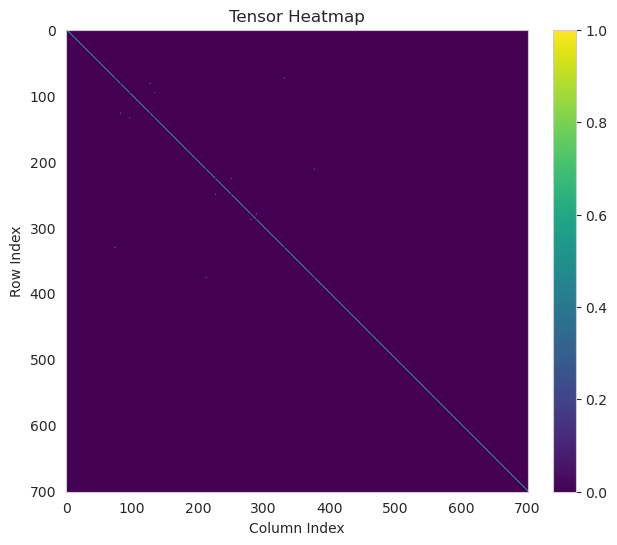

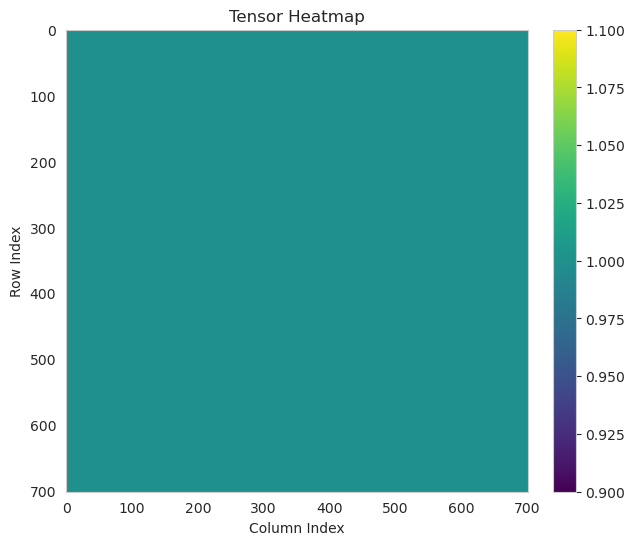

res_mask tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.

In [9]:

print(batch_data["full_seq"])

plot_tensor_heatmap(batch_data["full_bond_matrix"][0])
plot_tensor_heatmap(batch_data["full_bond_mask"][0])
off_diag_indices =(1- torch.eye(batch_data["full_bond_matrix"][0].shape[1], dtype=torch.bool, device=batch_data["full_bond_matrix"][0].device).float())
print("res_mask",batch_data["res_mask"])
print("head_mask",batch_data["full_head_mask"])
print("tail_mask",batch_data["full_tail_mask"])
print("bond_matrix off diag indices",torch.where(batch_data["full_bond_matrix"][0]*off_diag_indices == 1))

In [10]:
torch.set_printoptions(profile='full')
from torch.optim.lr_scheduler import CosineAnnealingLR,CosineAnnealingWarmRestarts
import torch.optim  as optim 
criterion_frame = LFrameLoss(w_trans=0.5, w_rot=1,gamma=1,d_clamp = 25)
criterion_seq = LseqLoss()
criterion_bond = DSMCrossEntropyLoss()
criterion_FAPE = FAPELoss(clamp_distance = 20)
criterion_clash =  OpenFoldClashLoss(device=device)
criterion_torsion = TorsionLossLegacy(focal_gamma=1)
link_csv_path = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv"
criterion_bond_coh = BondCoherenceLoss(link_csv_path=link_csv_path, device=device,t_geom_threshold=0.8)
criterion_sc_fape = SidechainFAPELoss()
model = sampler.sidechain_model
optimizer = optim.AdamW(model.parameters(), lr=5e-4,weight_decay=1e-5)
# scheduler = CosineAnnealingLR(optimizer, T_max=1000, eta_min=1e-5)
from torch.amp import autocast, GradScaler
use_amp = False
scaler = GradScaler("cuda",enabled=use_amp)

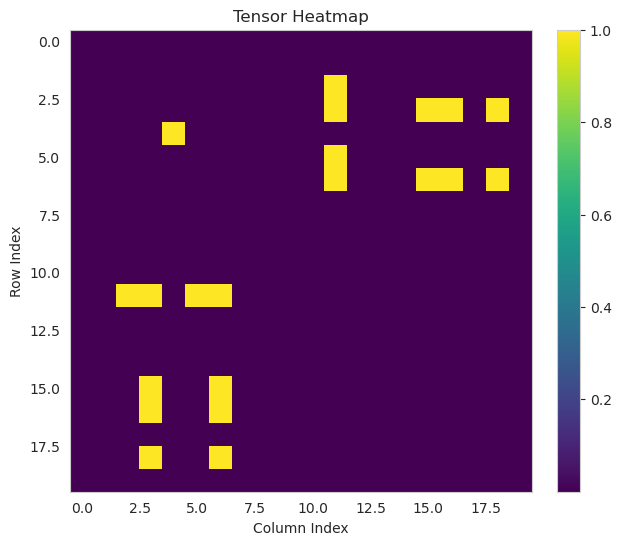

In [11]:
plot_tensor_heatmap(criterion_bond_coh.compat_matrix.cpu())

In [12]:
def calculate_norm(loss, params_to_check,name):
    if loss.item() == 0:
        print(f"{name} loss is zero, skipping gradient calculation.")
        return 0.0
    fape_grads = torch.autograd.grad(loss, params_to_check, retain_graph=True, allow_unused=True)
    total_norm = 0.0
    for grad in fape_grads:
        if grad is not None:
            # 确保梯度不是空的 (如果allow_unused=True)
            total_norm += grad.data.norm(2).item() ** 2
    print( f"{name} grad:", total_norm ** 0.5)
    return total_norm ** 0.5


with torch.autograd.detect_anomaly():

    import time 
    total_time = 0


    bond_indices_num = 0
    for i, batch_data in enumerate(dataloader_train):
        print("start "*10)
        # if (i+1) // 64 != 115 or(i+1) // 64 != 116:
        #     continue
        #with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=use_amp):

        print(batch_data['pdb_id'])
        start_time = time.time()
        loss_frame, loss_seq, loss_bond, loss_clash, loss_FAPE, loss_torsion, loss_bond_coh, loss_sc_fape, partial_T,  seq_pred, res_mask,bond_indices_numel = model_forward(
                                                        sampler,
                                                        batch_data,
                                                        criterion_frame,
                                                        criterion_seq,
                                                        criterion_bond,
                                                        criterion_FAPE,
                                                        criterion_torsion,
                                                        criterion_bond_coh,
                                                        criterion_sc_fape,
                                                        criterion_clash=criterion_clash
                                                        )

        print("loss frame",loss_frame.item())
        print("loss seq",loss_seq.item())
        print("loss bond",loss_bond.item())
        print("loss clash",loss_clash.item())
        print("loss FAPE",loss_FAPE.item())
        print("loss torsion",loss_torsion.item())
        print("loss bond_coh",loss_bond_coh.item())
        print("loss sc_fape",loss_sc_fape.item())
        print("partial_T",partial_T)
        pdb_id = batch_data['pdb_id']
        #loss_total = loss_frame + loss_seq + loss_bond + loss_clash + loss_FAPE + loss_torsion

            # 为了效率，我们只检查最后一个共享层的参数
        # params_to_check = list(model.parameters())
        
        # loss_dict = {'frame':loss_frame, 'seq':loss_seq, 'bond':loss_bond, 'clash':loss_clash, 'FAPE':loss_FAPE, 'torsion':loss_torsion}
        # if params_to_check: # 确保参数列表不为空
        #     for name, loss in loss_dict.items():
        #         print(f"{name} loss:", loss.item())
        #         fape_grad_norm = calculate_norm(loss, params_to_check,name)
        loss_total = loss_torsion *1 # + loss_sc_fape*0.0 + loss_bond_coh *1 + loss_clash *0.5
        #loss_total =  loss_frame+ loss_seq +  loss_bond + loss_clash +   loss_FAPE  + loss_torsion + loss_bond_coh + loss_sc_fape
        loss_total.backward()

        # for name, p in sampler.model.named_parameters():
        #     if p.requires_grad and p.grad is None:
        #         print("No grad:", name)

        # is_grad_nan_or_inf = torch.tensor([False])
        # for param in sampler.model.parameters():
        #     if param.grad is not None and (torch.isinf(param.grad).any() or torch.isnan(param.grad).any()):
        #         is_grad_nan_or_inf[0] = True
        #         print(f"Gradient is NaN or Inf for parameter: {param} at step {i} at pdb_id {pdb_id}")
        #         break # 发现一个就足够了，直接跳出循环
        #scaler.scale(loss_total).backward()


        # nn.utils.clip_grad_norm_(sampler.model.parameters(), 1)

        # total_norm = 0
        # for name, p in model.named_parameters():
        #     if p.grad is not None:
        #         param_norm = p.grad.data.norm(2)
        #         #if param_norm.item()>1:
        #         total_norm += param_norm.item() ** 2
        # total_norm = total_norm ** 0.5
        # print(f"Total gradient norm: {total_norm}")

        # max_norm = 5
        # torch.nn.utils.clip_grad_norm_(sampler.model.parameters(), max_norm=max_norm)
        # scaler.step(optimizer)
        # scaler.update()
        optimizer.step()
        optimizer.zero_grad()
        # scheduler.step()
        if loss_torsion.item() <=0.06 and loss_bond_coh.item() <=0.19:
            print("存在1")
            print(aaaaaaa)

        print("all time:", time.time() - start_time)

   


/tmp/ipykernel_2172346/740718441.py:15: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


[['A/1-A/377:seq_PNA:str_PNA', 'New_323-323']]
start start start start start start start start start start 
['AF-P38585-F1-model_v4_A']
motif_center tensor([[[-4.8406,  1.8564, -1.2233]]], device='cuda:0')
yuandian tensor([[-1.8117e-07, -1.8872e-07, -1.9879e-07]], device='cuda:0')
xyz_noised 0 tensor([[-29.8242,  -6.4706,  19.4479],
        [-29.4212,  -5.1626,  18.8889],
        [-27.9522,  -4.9576,  19.1979]], device='cuda:0')
xyz_noised 1 tensor([[-29.8242,  -6.4706,  19.4479],
        [-29.4212,  -5.1626,  18.8889],
        [-27.9522,  -4.9576,  19.1979]], device='cuda:0')
model forward time: 37.33088827133179
allatom time: 0.4853827953338623
[ClashLoss] between_sum(no_div)=0.895943 denom=4
[ClashLoss] within_sum(no_div)=0.000000 denom=1
[ClashLoss] total_sum(no_div)=0.895943
clash loss time: 0.0601048469543457
loss torchsion tensor(1.5793, device='cuda:0', grad_fn=<DivBackward0>)
torsion loss time: 0.018699169158935547
valid_pairs: 9398
final_penalty_mask_float: 12.0
valid
bond_ma

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from Bio.PDB import PDBParser
import numpy as np
from rfdiff.chemical import num2aa, aa_321
import torch

def are_collinear(p1, p2, p3, tol=1e-3):
    """Checks if three points are collinear."""
    if p1 is None or p2 is None or p3 is None:
        return False, "One or more points are missing"
    v1 = p2 - p1
    v2 = p3 - p1
    cross_product = np.cross(v1, v2)
    norm = np.linalg.norm(cross_product)
    if norm < tol:
        return True, f"Collinear, cross product norm: {norm:.4f}"
    return False, f"Not collinear, cross product norm: {norm:.4f}"

# --- Configuration ---
pdb_file = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/tests/output_new.pdb"
link_csv_path = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv"
bonds_in_batch = []

# --- Main script ---
print(f"Analyzing {pdb_file} for collinear atoms...")
link_df = pd.read_csv(link_csv_path)
parser = PDBParser(QUIET=True)
try:
    structure = parser.get_structure("generated", pdb_file)
    model = structure[0]
except FileNotFoundError:
    print(f"Error: PDB file not found at {pdb_file}. Please ensure model_forward() has been run.")
    # Exit if PDB doesn't exist.
    exit()


# Populate `bonds_in_batch` from the `batch_data` variable if it exists.
if 'batch_data' in locals() and not bonds_in_batch:
    print("Found 'batch_data', extracting bond information...")
    bond_matrix = batch_data['full_bond_matrix'].cpu()
    seq_target = batch_data['full_seq'].cpu()
    B, L = seq_target.shape
    # Exclude diagonal
    eye = torch.eye(L).repeat(B, 1, 1)
    bond_indices = torch.where((bond_matrix == 1) & (eye == 0))

    for b, i, j in zip(bond_indices[0], bond_indices[1], bond_indices[2]):
        res_name_i = aa_321.get(num2aa[seq_target[b, i].item()], 'UNK')
        res_name_j = aa_321.get(num2aa[seq_target[b, j].item()], 'UNK')
        bonds_in_batch.append((b.item(), i.item(), j.item(), res_name_i, res_name_j))

if not bonds_in_batch:
    print("Warning: `bonds_in_batch` is empty. No bonds to analyze.")
    print("Please run the cell that defines `batch_data` and calls `model_forward`.")

for bond_info in bonds_in_batch:
    b, resi_i, resj_j, resn_i, resn_j = bond_info
    print(f"\n--- Analyzing bond: Batch {b}, {resn_i}{resi_i+1} <-> {resn_j}{resj_j+1} ---")

    # Find rule in link.csv, including fallbacks for 'ALL'
    rule = link_df[((link_df['res1'] == resn_i) & (link_df['res2'] == resn_j)) |
                   ((link_df['res1'] == resn_j) & (link_df['res2'] == resn_i))]
    if rule.empty:
        rule = link_df[((link_df['res1'] == resn_i) & (link_df['res2'] == 'ALL')) |
                       ((link_df['res1'] == 'ALL') & (link_df['res2'] == resn_j))]
    if rule.empty:
        print(f"No rule found for {resn_i}-{resn_j}")
        continue
    
    rule = rule.iloc[0]

    def get_coords(res_idx, atom_name):
        try:
            # PDB residue numbering is 1-based, our indices are 0-based
            return model['A'][res_idx + 1][atom_name].get_coord()
        except KeyError:
            print(f"Warning: Atom '{atom_name}' not found in residue {res_idx+1}")
            return None

    # Check dihedral_1
    if pd.notna(rule.get('dihedral_1_anchor_i')) and pd.notna(rule.get('dihedral_1_anchor_j')):
        p1_name, p2_name = rule['atom1'], rule['atom2']
        p0_name, p3_name = rule['dihedral_1_anchor_i'], rule['dihedral_1_anchor_j']
        
        p0, p1 = get_coords(resi_i, p0_name), get_coords(resi_i, p1_name)
        p2, p3 = get_coords(resj_j, p2_name), get_coords(resj_j, p3_name)

        print(f"Dihedral 1 points: {p0_name}({resi_i+1}), {p1_name}({resi_i+1}), {p2_name}({resj_j+1}), {p3_name}({resj_j+1})")
        is_col, msg = are_collinear(p0, p1, p2)
        if is_col: print(f"  COLLINEARITY DETECTED in ({p0_name}, {p1_name}, {p2_name}): {msg}")
        is_col, msg = are_collinear(p1, p2, p3)
        if is_col: print(f"  COLLINEARITY DETECTED in ({p1_name}, {p2_name}, {p3_name}): {msg}")

    # Check dihedral_2
    if pd.notna(rule.get('dihedral_2_anchor_i')) and pd.notna(rule.get('dihedral_2_anchor_j')):
        p1_name, p2_name = rule['atom1'], rule['atom2']
        p0_name, p3_name = rule['dihedral_2_anchor_i'], rule['dihedral_2_anchor_j']

        p0, p1 = get_coords(resi_i, p0_name), get_coords(resi_i, p1_name)
        p2, p3 = get_coords(resj_j, p2_name), get_coords(resj_j, p3_name)

        print(f"Dihedral 2 points: {p0_name}({resi_i+1}), {p1_name}({resi_i+1}), {p2_name}({resj_j+1}), {p3_name}({resj_j+1})")
        is_col, msg = are_collinear(p0, p1, p2)
        if is_col: print(f"  COLLINEARITY DETECTED in ({p0_name}, {p1_name}, {p2_name}): {msg}")
        is_col, msg = are_collinear(p1, p2, p3)
        if is_col: print(f"  COLLINEARITY DETECTED in ({p1_name}, {p2_name}, {p3_name}): {msg}")



In [ ]:

#with torch.autograd.detect_anomaly():
loss_frame, loss_seq, loss_bond, loss_clash, loss_FAPE, loss_torsion, loss_bond_coh, loss_sc_fape, partial_T,  seq_pred, res_mask,bond_indices_numel = model_forward(sampler,batch_data,
                                                criterion_frame,
                                                criterion_seq,
                                                criterion_bond,
                                                criterion_FAPE,
                                                criterion_torsion,
                                                criterion_bond_coh,
                                                criterion_sc_fape,
                                                criterion_clash=criterion_clash
                                                )
print("loss frame",loss_frame)
print("loss seq",loss_seq)
print("loss bond",loss_bond)
print("loss clash",loss_clash)
print("loss FAPE",loss_FAPE)
print("loss torsion",loss_torsion)
print("loss bond_coh",loss_bond_coh)
print("loss sc_fape",loss_sc_fape)
print("partial_T",partial_T)
#loss_total = loss_frame + loss_seq + loss_bond + loss_clash + loss_FAPE + loss_torsion
#loss_total =  loss_frame+ loss_seq + loss_bond + loss_clash +  loss_torsion +loss_FAPE  + loss_bond_coh + loss_sc_fape
loss_total = loss_sc_fape
loss_total.backward()


# 监控并打印梯度范数
total_norm = 0
for name, p in sampler.model.named_parameters():
    if p.grad is not None:
        param_norm = p.grad.data.norm(2)
        #if param_norm.item()>1:
        print(name,param_norm.item())
        total_norm += param_norm.item() ** 2
total_norm = total_norm ** 0.5
print(f"Total gradient norm: {total_norm}")

#更新梯度


optimizer.step()
optimizer.zero_grad()
